# Norm approximation problem
Reformulating an unconstrained problem introducting equality constraints might lead to a dual problem that is more useful than the dual of the original problem. As an example we use the  *Norm approximation problem* (p. 254, Convex Optimization, Boyd):

$$minimize \quad ‖Ax − b‖$$

The reformulated problem:
$$minimize \quad ‖y‖$$
$$s.t \quad Ax-b = y$$

In [6]:
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch

import cooper

In [94]:
class NormApproximation(cooper.ConstrainedMinimizationProblem):
    def __init__(self, A, b, norm):
        self.A = A
        self.b = b
        self.norm = norm
        super().__init__(is_constrained=True)

    def closure(self, x, y):

        loss = torch.linalg.norm(y, self.norm)

        eq_defect = torch.matmul(self.A, x) - self.b - y

        return cooper.CMPState(
            loss=loss, eq_defect=eq_defect
        )

In [119]:
n_vars = 8
n_eq = 10

A = torch.rand(size=(n_eq,n_vars))
b = torch.rand(size=(n_eq,))
norm = 2
cmp = NormApproximation(A, b, norm)
formulation = cooper.LagrangianFormulation(cmp)

x = torch.nn.Parameter(torch.rand(n_vars,))
y = torch.nn.Parameter(torch.rand(n_eq,))

primal_optimizer = cooper.optim.ExtraSGD([x, y], lr=3e-2, momentum=0.7)
dual_optimizer = cooper.optim.partial_optimizer(
    cooper.optim.ExtraSGD, lr=9e-4, momentum=0.7
    )

coop = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
    dual_optimizer=dual_optimizer,
)

In [120]:
state_history = cooper.StateLogger(save_metrics=["loss", "eq_defect", "eq_multipliers"])

for iter_num in range(50):

    coop.zero_grad()
    lagrangian = formulation.composite_objective(cmp.closure, x, y)
    formulation.custom_backward(lagrangian)
    coop.step(cmp.closure, x, y)

    # Store optimization metrics at each step
    partial_dict = {"params": copy.deepcopy(y)}
    state_history.store_metrics(formulation, iter_num, partial_dict)

    # if iter_num % 10 == 0:
print(cmp.state)

CMPState(loss=tensor(0.0306, grad_fn=<LinalgVectorNormBackward0>), ineq_defect=None, eq_defect=tensor([-1.5360, -1.2667, -1.9549, -1.1825, -1.3704, -0.8754, -1.4578, -1.8713,
        -1.1987, -1.5948], grad_fn=<SubBackward0>), proxy_ineq_defect=None, proxy_eq_defect=None, misc=None)


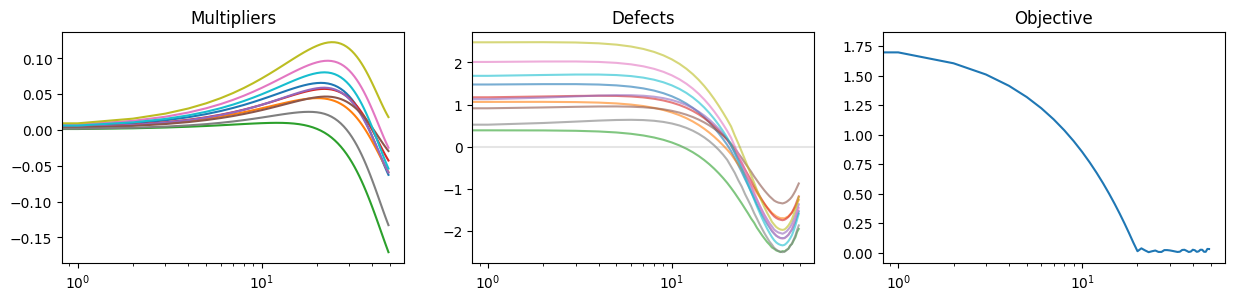

In [121]:
all_metrics = state_history.unpack_stored_metrics()

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 3))

ax0.plot(all_metrics["iters"], np.stack(all_metrics["eq_multipliers"]))
ax0.set_title("Multipliers")

ax1.plot(all_metrics["iters"], np.stack(all_metrics["eq_defect"]), alpha=0.6)
ax1.axhline(0.0, c="gray", alpha=0.2)
ax1.set_title("Defects")

ax2.plot(all_metrics["iters"], all_metrics["loss"])
ax2.set_title("Objective")

[_.semilogx() for _ in (ax0, ax1, ax2)]
plt.show()

# Equality constrained norm minimization
$$minimize \quad ‖x‖$$
$$s.t \quad Ax = b$$

In [126]:
class NormMinimization(cooper.ConstrainedMinimizationProblem):
    def __init__(self, A, b, norm):
        self.A = A
        self.b = b
        self.norm = norm
        super().__init__(is_constrained=True)

    def closure(self, x):

        loss = torch.linalg.norm(x, self.norm)

        eq_defect = torch.matmul(self.A, x) - self.b

        return cooper.CMPState(
            loss=loss, eq_defect=eq_defect
        )

## Example of infinite solutions
$$
A=\left[\begin{array}{lll}
0 & 5 & 3 \\
0 & 4 & 4 \\
0 & 0 & 2
\end{array}\right] \quad b=\left[\begin{array}{l}
8 \\
8 \\
2
\end{array}\right] \quad x=\left[\begin{array}{l}
x_{1} \\
x_{2} \\
x_{3}
\end{array}\right]
$$
The system $A x-b=0$ has infinite solutions since $x_{1}$ can take any value. Clearly, the value of $x_{1}$ that minimizes the norm is $x_{1}=0$ and the minimum value of $\|x\|_{2}$ is $\sqrt{2}$.

In [147]:
# Example of infinite solutions
n_vars = 3
n_eq = 3

A = torch.tensor([[0, 5.0, 3.0],[0, 4.0, 4.0],[0, 0, 2.0]])
b = torch.tensor([8.0, 8.0, 2.0]).squeeze()
norm = 2
cmp = NormMinimization(A, b, norm)
formulation = cooper.LagrangianFormulation(cmp)

x = torch.nn.Parameter(torch.rand(n_vars,))

primal_optimizer = cooper.optim.ExtraSGD([x], lr=3e-2, momentum=0.7)
dual_optimizer = cooper.optim.partial_optimizer(
    cooper.optim.ExtraSGD, lr=9e-8, momentum=0.7
    )

coop = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
    dual_optimizer=dual_optimizer,
)

In [148]:
state_history = cooper.StateLogger(save_metrics=["loss", "eq_defect", "eq_multipliers"])

for iter_num in range(500):

    coop.zero_grad()
    lagrangian = formulation.composite_objective(cmp.closure, x)
    formulation.custom_backward(lagrangian)
    coop.step(cmp.closure, x)

    # Store optimization metrics at each step
    partial_dict = {"params": copy.deepcopy(x)}
    state_history.store_metrics(formulation, iter_num, partial_dict)

    # if iter_num % 10 == 0:
print(cmp.state)

CMPState(loss=tensor(0.0141, grad_fn=<LinalgVectorNormBackward0>), ineq_defect=None, eq_defect=tensor([-7.9628, -7.9498, -1.9745], grad_fn=<SubBackward0>), proxy_ineq_defect=None, proxy_eq_defect=None, misc=None)


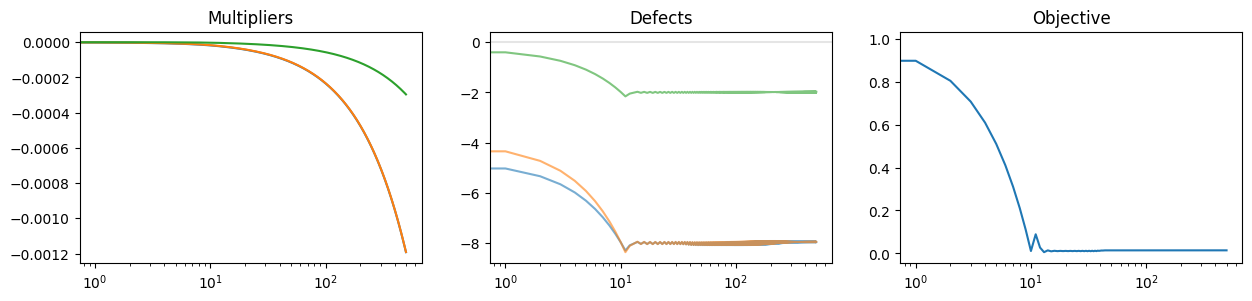

In [149]:
all_metrics = state_history.unpack_stored_metrics()

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 3))

ax0.plot(all_metrics["iters"], np.stack(all_metrics["eq_multipliers"]))
ax0.set_title("Multipliers")

ax1.plot(all_metrics["iters"], np.stack(all_metrics["eq_defect"]), alpha=0.6)
ax1.axhline(0.0, c="gray", alpha=0.2)
ax1.set_title("Defects")

ax2.plot(all_metrics["iters"], all_metrics["loss"])
ax2.set_title("Objective")

[_.semilogx() for _ in (ax0, ax1, ax2)]
plt.show()